# Continuous Control

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [ ]:
!pip -q install ./python

The environments corresponding to both versions of the environment are already saved in the Workspace and can be accessed at the file paths provided below.  

Please select one of the two options below for loading the environment.

In [ ]:
from unityagents import UnityEnvironment
import numpy as np

# select this option to load version 1 (with a single agent) of the environment
#env = UnityEnvironment(file_name='/data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64')

##For local windows implementation
env = UnityEnvironment(file_name='C:/Users/adamb/OneDrive/Documents/Udacity Reinforcement Learning/3. Policy Base Methods/p2_continous_control/Reacher_Windows_x86_64/Reacher')

# select this option to load version 2 (with 20 agents) of the environment
# env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')

Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [ ]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [ ]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [ ]:
env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

When finished, you can close the environment.

In [ ]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

# 5. Initial Implementation 

In [ ]:
##Not required for local implementations
#!pip -q install ./python

In [1]:
import numpy as np
import torch
from collections import deque
import matplotlib.pyplot as plt
import datetime

from unityagents import UnityEnvironment
from model import Actor, Critic
from ddpg_agent import Agent, OUNoise, ReplayBuffer

In [2]:
%matplotlib inline

In [3]:
##Instantiate environment
# select this option to load version 1 (with a single agent) of the environment
#env = UnityEnvironment(file_name='/data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64')

##For local windows implementation
env = UnityEnvironment(file_name='C:/Users/adamb/OneDrive/Documents/Udacity Reinforcement Learning/3. Policy Base Methods/p2_continous_control/Reacher_Windows_x86_64/Reacher')


# select this option to load version 2 (with 20 agents) of the environment
# env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [5]:
##Get 'environment' variables
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]

Number of agents: 1
Size of each action: 4


In [6]:
##Instantiate Agent
agent = Agent(state_size = state_size, action_size = action_size, random_seed=10)

In [7]:
def ddpg_train(n_episodes=200, max_t=200, print_every=10, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    scores_deque = deque(maxlen=print_every)
    scores = []
    reward_avg = []
    
    scores_avg = []
    
    eps = eps_start
    
    for i_episode in range(1, n_episodes+1):
        agent.reset()
        
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]
        #states = env_info.vector_observations
        score = 0
        #score = np.zeros(num_agents)

        reward_temp = 0
        steps = 0
        #print(i_episode)
        
        for t in range(max_t):
            steps += 1
            ##Determine action to take with clipping
            action = agent.act(state, eps, add_noise=True)
            #actions = agent.act(states, add_noise=False)
            
            ##Execute action
            env_info = env.step(action)[brain_name]
            #env_info = env.step(actions)[brain_name]
            
            ##Get results of action
            next_state = env_info.vector_observations[0]
            reward = env_info.rewards[0]                  
            done = env_info.local_done[0]  
            #next_states = env_info.vector_observations
            #rewards = env_info.rewards
            #dones = env_info.local_done
        
            ##Update agent
            agent.step(state, action, reward, next_state, done)
            #agent.step(states, actions, rewards, next_states, dones)
            
            ##Save scores
            score += reward
            #score += env_info.rewards
            
            state = next_state
            #states = next_states
            
            if done:
                break
            #if np.any(dones):
            #    break
        
        eps = max(eps_end, eps_decay*eps)
        
        print(datetime.datetime.now())
        print('Score: ' + str(score))
        reward_avg.append(score / steps)
        
        #reward_avg += [sum(reward_temp) / len(reward_temp)]
        
        scores_deque.append(score)
        scores.append(score)
        
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)), end="")
        torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
        torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        
        scores_avg.append(np.mean(scores_deque))
        #print(reward_avg)
        print()
        

    return scores, reward_avg, scores_avg

In [8]:
scores, reward_avg, scores_avg = ddpg_train(n_episodes=200, max_t=500, print_every=20, eps_start=1.0, eps_end=0.01, eps_decay=0.995)

C:\Users\adamb\Anaconda3\envs\testenv4\lib\site-packages\torch\nn\functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


2020-02-05 13:21:56.102083
Score: 0.0
Episode 1	Average Score: 0.00


C:\Users\adamb\OneDrive\Documents\Udacity Reinforcement Learning\3. Policy Base Methods\p2_continous_control\ddpg_agent.py:100: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(self.critic_local.parameters(), 1)


2020-02-05 13:22:11.708697
Score: 0.7199999839067459
Episode 2	Average Score: 0.36
2020-02-05 13:22:27.387741
Score: 0.0
Episode 3	Average Score: 0.24
2020-02-05 13:22:43.102018
Score: 0.17999999597668648
Episode 4	Average Score: 0.22
2020-02-05 13:22:58.970940
Score: 0.0
Episode 5	Average Score: 0.18
2020-02-05 13:23:14.567450
Score: 0.0
Episode 6	Average Score: 0.15
2020-02-05 13:23:30.533174
Score: 0.0
Episode 7	Average Score: 0.13
2020-02-05 13:23:46.735388
Score: 0.0
Episode 8	Average Score: 0.11
2020-02-05 13:24:03.375529
Score: 0.0
Episode 9	Average Score: 0.10
2020-02-05 13:24:19.869752
Score: 0.0
Episode 10	Average Score: 0.09
2020-02-05 13:24:35.662777
Score: 0.0
Episode 11	Average Score: 0.08
2020-02-05 13:24:51.499925
Score: 0.0
Episode 12	Average Score: 0.07
2020-02-05 13:25:07.567957
Score: 0.8899999801069498
Episode 13	Average Score: 0.14
2020-02-05 13:25:23.904490
Score: 0.0
Episode 14	Average Score: 0.13
2020-02-05 13:25:39.763595
Score: 0.0
Episode 15	Average Score: 0

2020-02-05 13:51:37.922018
Score: 0.1599999964237213
Episode 112	Average Score: 0.04
2020-02-05 13:51:54.289066
Score: 0.4899999890476465
Episode 113	Average Score: 0.06
2020-02-05 13:52:10.768151
Score: 0.0
Episode 114	Average Score: 0.06
2020-02-05 13:52:27.210204
Score: 0.0
Episode 115	Average Score: 0.06
2020-02-05 13:52:43.701231
Score: 0.0
Episode 116	Average Score: 0.06
2020-02-05 13:53:00.237954
Score: 0.0
Episode 117	Average Score: 0.06
2020-02-05 13:53:16.754955
Score: 0.0
Episode 118	Average Score: 0.05
2020-02-05 13:53:33.335490
Score: 0.0
Episode 119	Average Score: 0.03
2020-02-05 13:53:49.810854
Score: 0.0
Episode 120	Average Score: 0.03

2020-02-05 13:54:06.319853
Score: 0.0
Episode 121	Average Score: 0.03
2020-02-05 13:54:22.911400
Score: 0.0
Episode 122	Average Score: 0.03
2020-02-05 13:54:39.521934
Score: 0.29999999329447746
Episode 123	Average Score: 0.05
2020-02-05 13:54:55.976723
Score: 0.0
Episode 124	Average Score: 0.05
2020-02-05 13:55:09.185322
Score: 0.0
Episo

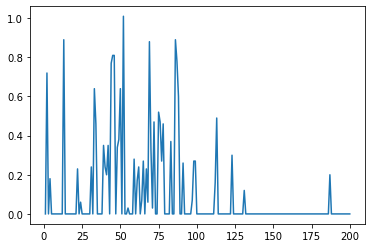

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)

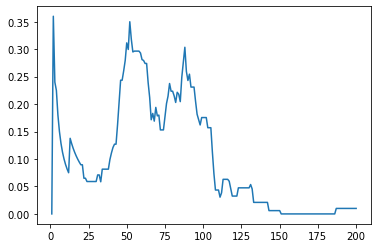

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores_avg)+1), scores_avg)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()